In [ ]:
# -*- coding: utf-8 -*-
# -*- author : Vincent Roduit -*-
# -*- date : 2023-11-25 -*-
# -*- Last revision: 2023-11-25 -*-
# -*- python version : 3.11.6 -*-
# -*- Description: Try notebook-*-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ml-project-2-team-slo/source

/content/drive/MyDrive/ml-project-2-team-slo/source


In [1]:
#import libraries
%matplotlib inline
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
#import files
from load_datas import*
from constants import*
from visualization import*
from data_processing import*
from data_augmentation import*

In [3]:
imgs, gt_imgs = load_datas(NB_IMAGES_MAX)

Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png


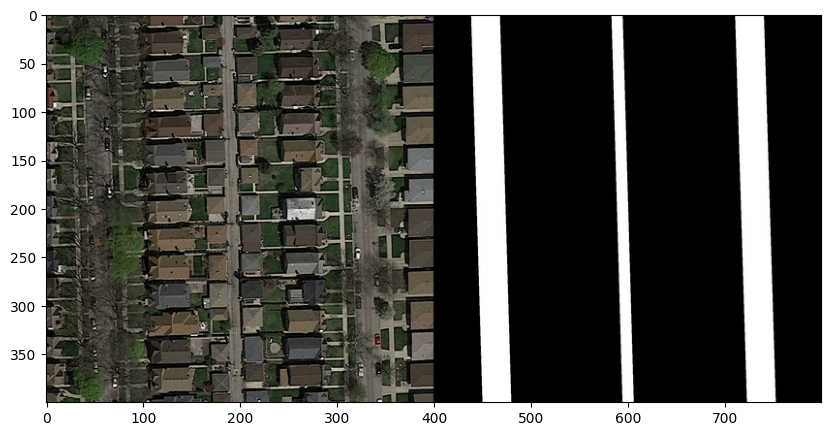

In [4]:
visualize(imgs, gt_imgs)

In [22]:
Processing = ProcessingData(imgs, gt_imgs)
Processing.create_patches()
Processing.permute_axis()
Processing.create_labels()
Processing.balance_dataset()

Creating patches...
Done!
Permuting axis...
Done!
Creating labels...
Done!
Balancing dataset...
Done!


In [24]:
print(f'Percentage of road pixels in the dataset: {Processing.gt_imgs_patches.sum() /Processing.gt_imgs_patches.shape[0]*100}%')

Percentage of road pixels in the dataset: 50.0%


In [ ]:
print(f'Processing.imgs.shape = {Processing.imgs.shape}')
print(f'Processing.gt_imgs.shape = {Processing.gt_imgs.shape}')
print(f'Processing.imgs_patches.shape = {Processing.imgs_patches.shape}')
print(f'Processing.gt_imgs_patches.shape = {Processing.gt_imgs_patches.shape}')
print(f'Processing.imgs_train.shape = {Processing.imgs_train.shape}')

Processing.imgs.shape = (100, 400, 400, 3)
Processing.gt_imgs.shape = (100, 400, 400)
Processing.imgs_patches.shape = (62500, 3, 16, 16)
Processing.gt_imgs_patches.shape = (62500,)
Processing.imgs_train.shape = (35000, 3, 16, 16)


In [ ]:
means, stds = Processing.compute_mean_std()
Augmented_Images = DataAugmentation(imgs, means, stds)
Augmented_Images = Augmented_Images.noisyImages()

In [ ]:
set_gt = np.tile(A=gt_imgs,reps=(2,1,1))
set_img = np.concatenate((imgs, Augmented_Images))

In [ ]:
Processing = ProcessingData(set_img, set_gt)
Processing.create_patches()
Processing.create_labels()
Processing.create_sets()

In [ ]:
visualize(set_img, set_gt, index=10)

In [ ]:
import numpy as np

import torch
import torchvision
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from training_utils import*

In [ ]:
# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [27]:
import torch.nn.functional as F
import torch.nn as nn

class CorrectBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        # Adjust the input channels to match the input size (3 channels)
        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Adjust the pooling size to match the input size
        self.avg_pool = nn.AvgPool2d(4)

        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Check if the input size is smaller than the kernel size of the average pooling layer
        if out.size(-1) < 4 or out.size(-2) < 4:
            out = F.adaptive_avg_pool2d(out, (1, 1))
        else:
            out = self.avg_pool(out)

        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



In [28]:
BATCH_SIZE = 128
TEST_BATCH_SIZE = 256

In [29]:
train_dataloader = DataLoader(
    dataset=list(zip(Processing.imgs_train, Processing.gt_imgs_train)),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=list(zip(Processing.imgs_validation,Processing.gt_imgs_validation)),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=list(zip(Processing.imgs_validation,Processing.gt_imgs_test)),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

In [30]:
# initialize the model
model = ResNet(block=CorrectBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

train_losses, valid_losses, valid_accs = fit(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE,
    scheduler = scheduler
)
test_loss_bonus2,test_acc_bonus2 = predict(model=model, test_dataloader=test_dataloader, device=DEVICE)


Epoch 0: Train Loss=0.4925, Validation Loss=0.4031, Validation acc=81.0067
Epoch 1: Train Loss=0.3866, Validation Loss=0.3782, Validation acc=82.9933
Epoch 2: Train Loss=0.3692, Validation Loss=0.6192, Validation acc=76.0533
Epoch 3: Train Loss=0.3597, Validation Loss=0.4279, Validation acc=79.8400
Epoch 4: Train Loss=0.3330, Validation Loss=0.3921, Validation acc=80.0800
Epoch 5: Train Loss=0.3188, Validation Loss=0.4895, Validation acc=77.7200
Epoch 6: Train Loss=0.2931, Validation Loss=0.3547, Validation acc=83.3867
Epoch 7: Train Loss=0.2727, Validation Loss=0.3628, Validation acc=84.3200
Epoch 8: Train Loss=0.2468, Validation Loss=0.3675, Validation acc=84.1933
Epoch 9: Train Loss=0.2223, Validation Loss=0.4231, Validation acc=82.9533
Epoch 10: Train Loss=0.1926, Validation Loss=0.4303, Validation acc=83.8333
Epoch 11: Train Loss=0.1696, Validation Loss=0.4412, Validation acc=83.3333
Epoch 12: Train Loss=0.1444, Validation Loss=0.5398, Validation acc=82.3667
Epoch 13: Train Loss=0

In [ ]:
for data, target in test_dataloader:
    print(data[0].shape)